<a href="https://colab.research.google.com/github/makkimaki/siamese-network-coursera-tutorial/blob/main/Deep_Learning_with_PyTorch_Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-1hq5fbmr
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-1hq5fbmr
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [47]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

fatal: destination path 'Person-Re-Id-Dataset' already exists and is not an empty directory.


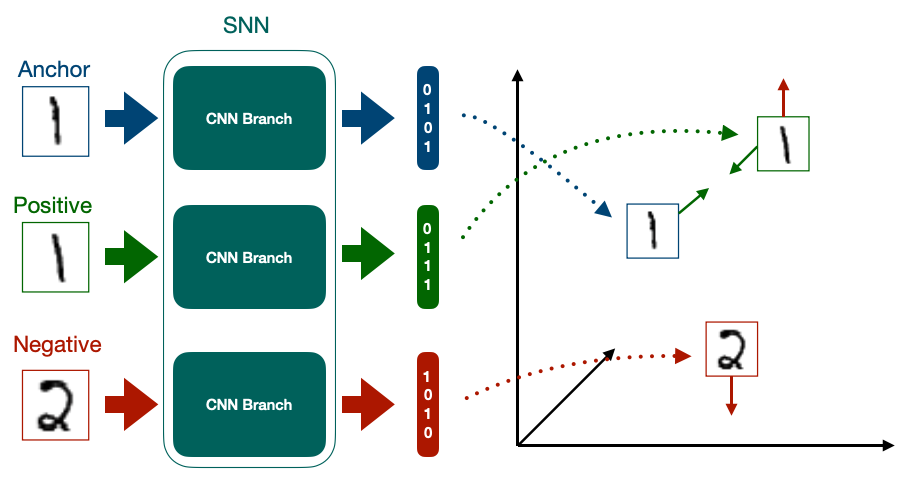

# Imports

In [48]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [49]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [50]:
DATA_DIR = "/content/Person-Re-Id-Dataset/train/"
CSV_FILE = "/content/Person-Re-Id-Dataset/train.csv"

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = "cuda"

In [51]:
df = pd.read_csv(CSV_FILE)
df.head() 

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


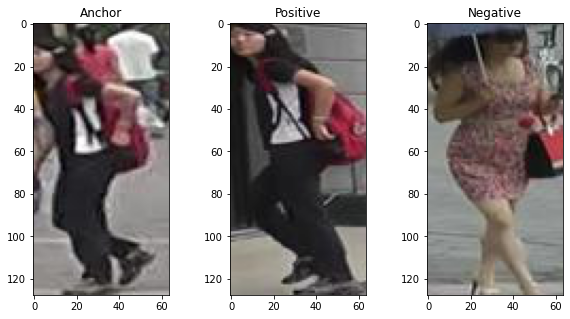

In [52]:
row = df.iloc[4]

Anchor_img = io.imread(DATA_DIR + row.Anchor)
Positive_img = io.imread(DATA_DIR + row.Positive)
Negative_img = io.imread(DATA_DIR + row.Negative)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))

ax1.set_title("Anchor")
ax1.imshow(Anchor_img)

ax2.set_title("Positive")
ax2.imshow(Positive_img)

ax3.set_title("Negative")
ax3.imshow(Negative_img)

In [53]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Create APN Dataset 

In [54]:
class APN_Dataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        Anchor_img = io.imread(DATA_DIR + row.Anchor)
        Positive_img = io.imread(DATA_DIR + row.Positive)
        Negative_img = io.imread(DATA_DIR + row.Negative)

        A_img = torch.from_numpy(Anchor_img).permute(2, 0, 1) / 255.0
        P_img = torch.from_numpy(Positive_img).permute(2, 0, 1) / 255.0
        N_img = torch.from_numpy(Negative_img).permute(2, 0, 1) / 255.0

        return A_img, P_img, N_img

In [55]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 3200
Size of validset: 800


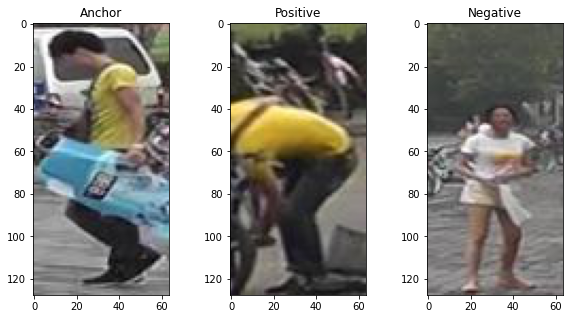

In [56]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [57]:
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(validset, batch_size=BATCH_SIZE)

In [58]:
print(f"No. of batches in trainloader : {len(train_loader)}")
print(f"No. of batches in validloader : {len(valid_loader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [59]:
for A, P, N in train_loader:
    break;
    
print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model 

In [60]:
class APN_Model(nn.Module):
    def __init__(self, emb_size=512):
        super(APN_Model, self).__init__()

        self.efficientnet = timm.create_model("efficientnet_b0", pretrained=True)
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings


In [61]:
model = APN_Model()
model.to(DEVICE);

# Create Train and Eval function

In [62]:
def train_fn(model, dataloader, optimizer, criterion):

    model.train()  # ON dropout
    total_loss = 0.0

    for A, P, N in tqdm(dataloader):
        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [63]:
def eval_fn(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for A, P, N in tqdm(dataloader):
            A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)

            loss = criterion(A_embs, P_embs, N_embs)

            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()

            total_loss += loss.item()

    return total_loss / len(dataloader)

In [64]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Create Training Loop

In [65]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

    train_loss = train_fn(model, train_loader, optimizer, criterion)
    valid_loss = eval_fn(model, valid_loader, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model.pt")
        best_valid_loss = valid_loss
        print("SAVED_WEIGHTS_SUCCESS")

    print(f"EPOCHS : {i+1} train_loss: {train_loss} / valid_loss: {valid_loss}")

100%|██████████| 25/25 [00:02<00:00,  8.68it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 1 train_loss: 0.6163570433855057 / valid_loss: 0.47120004534721377


100%|██████████| 25/25 [00:02<00:00, 11.01it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 2 train_loss: 0.3372017377614975 / valid_loss: 0.33196899890899656


100%|██████████| 25/25 [00:02<00:00, 10.93it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 3 train_loss: 0.18880382150411607 / valid_loss: 0.23516135454177856


100%|██████████| 25/25 [00:04<00:00,  5.38it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 4 train_loss: 0.12523690909147261 / valid_loss: 0.20939598262310027


100%|██████████| 25/25 [00:02<00:00, 10.58it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 5 train_loss: 0.09060129195451737 / valid_loss: 0.17704871118068696


100%|██████████| 25/25 [00:02<00:00, 11.01it/s]


EPOCHS : 6 train_loss: 0.06686106473207473 / valid_loss: 0.19877442538738252


100%|██████████| 25/25 [00:02<00:00, 11.10it/s]


EPOCHS : 7 train_loss: 0.06479005500674248 / valid_loss: 0.22622382879257202


100%|██████████| 25/25 [00:04<00:00,  5.65it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 8 train_loss: 0.07279393315315247 / valid_loss: 0.1644705355167389


100%|██████████| 25/25 [00:02<00:00,  9.10it/s]


EPOCHS : 9 train_loss: 0.04307958379387856 / valid_loss: 0.1831932073831558


100%|██████████| 25/25 [00:02<00:00, 11.10it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 10 train_loss: 0.05250883162021637 / valid_loss: 0.1397402763366699


100%|██████████| 25/25 [00:02<00:00,  9.49it/s]


EPOCHS : 11 train_loss: 0.06337053522467613 / valid_loss: 0.17983516573905944


100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


EPOCHS : 12 train_loss: 0.0332308042794466 / valid_loss: 0.15538680851459502


100%|██████████| 25/25 [00:02<00:00, 10.71it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 13 train_loss: 0.040281138494610784 / valid_loss: 0.11941508948802948


100%|██████████| 25/25 [00:02<00:00, 10.85it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 14 train_loss: 0.02232716590166092 / valid_loss: 0.11239355683326721


100%|██████████| 25/25 [00:02<00:00, 10.95it/s]

EPOCHS : 15 train_loss: 0.03753914788365364 / valid_loss: 0.14615530014038086


# Get Anchor Embeddings

In [71]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR + i)
            A = torch.from_numpy(A).permute(2,0,1) / 255.0
            A = A.to(DEVICE)
            A_enc = model(A.unsqueeze(0))   # Add batch dimension! (c, h, w) -> (1, c, h, w)
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis=1)
    
    return df_enc

In [72]:
model.load_state_dict(torch.load("best_model.pt"))
df_enc = get_encoding_csv(model, df["Anchor"])

100%|██████████| 4000/4000 [00:53<00:00, 74.33it/s]


,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.250114,0.494783,0.009810,-0.732846,0.118446,-0.221969,0.103424,0.891988,0.515678,...,-0.218770,0.600552,-0.262553,0.248823,0.163142,0.388245,0.458203,-0.134141,0.294189,0.110278
1,1420_c3s3_061978_03.jpg,0.270723,0.955863,0.238049,-1.164061,0.179716,-0.041451,-0.188957,1.220059,0.556833,...,-0.279196,0.622364,-0.123209,0.334951,0.267512,0.507485,0.734697,-0.078519,0.617060,0.265223
2,1420_c5s3_062565_05.jpg,0.203386,0.631593,0.237753,-0.736898,0.252453,-0.130955,0.081234,0.809739,0.376242,...,-0.212905,0.507573,-0.258500,0.386679,0.110313,0.389058,0.419091,-0.112626,0.360796,0.255657
3,1420_c6s3_085592_04.jpg,0.136768,0.319301,0.475380,0.532344,0.155536,-0.178292,0.409043,0.686562,0.371293,...,-0.208954,-0.029825,0.025915,0.026791,0.436428,0.175249,-0.004431,-0.039803,-0.072567,0.308492
4,0663_c5s3_085987_03.jpg,-0.715970,-0.590431,0.303449,-0.744165,-1.049342,-0.977391,0.573246,-0.557328,-1.132398,...,-0.014168,-0.358882,-0.636656,-0.194512,-0.210131,-0.066379,0.154008,0.557143,-0.235387,-0.644459


In [74]:
df_enc.to_csv("database.csv", index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.250114,0.494783,0.009810,-0.732846,0.118446,-0.221969,0.103424,0.891988,0.515678,...,-0.218770,0.600552,-0.262553,0.248823,0.163142,0.388245,0.458203,-0.134141,0.294189,0.110278
1,1420_c3s3_061978_03.jpg,0.270723,0.955863,0.238049,-1.164061,0.179716,-0.041451,-0.188957,1.220059,0.556833,...,-0.279196,0.622364,-0.123209,0.334951,0.267512,0.507485,0.734697,-0.078519,0.617060,0.265223
2,1420_c5s3_062565_05.jpg,0.203386,0.631593,0.237753,-0.736898,0.252453,-0.130955,0.081234,0.809739,0.376242,...,-0.212905,0.507573,-0.258500,0.386679,0.110313,0.389058,0.419091,-0.112626,0.360796,0.255657
3,1420_c6s3_085592_04.jpg,0.136768,0.319301,0.475380,0.532344,0.155536,-0.178292,0.409043,0.686562,0.371293,...,-0.208954,-0.029825,0.025915,0.026791,0.436428,0.175249,-0.004431,-0.039803,-0.072567,0.308492
4,0663_c5s3_085987_03.jpg,-0.715970,-0.590431,0.303449,-0.744165,-1.049342,-0.977391,0.573246,-0.557328,-1.132398,...,-0.014168,-0.358882,-0.636656,-0.194512,-0.210131,-0.066379,0.154008,0.557143,-0.235387,-0.644459


# Inference

In [75]:
def euclidean_dist(img_enc, anc_enc_arr):
    """

    Args:
        img_enc (): 
        anc_enc_arr (): encoded anchor database
    
    Return:
        dist (): distance matrix?
        

    """
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc-anc_enc_arr).T))

    return dist

In [76]:
idx = 0
img_name = df_enc["Anchor"].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
    img = img.to(DEVICE)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()


In [77]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc["Anchor"]

In [78]:
# calculate the distance of each image
# e.g.) 0-1, 0-2, 0-3, ...
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc, anc_enc_arr[i: i+1, :])
    distance = np.append(distance, dist)


In [79]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.7/dist-packages/networkx/drawing/layout.py:727: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


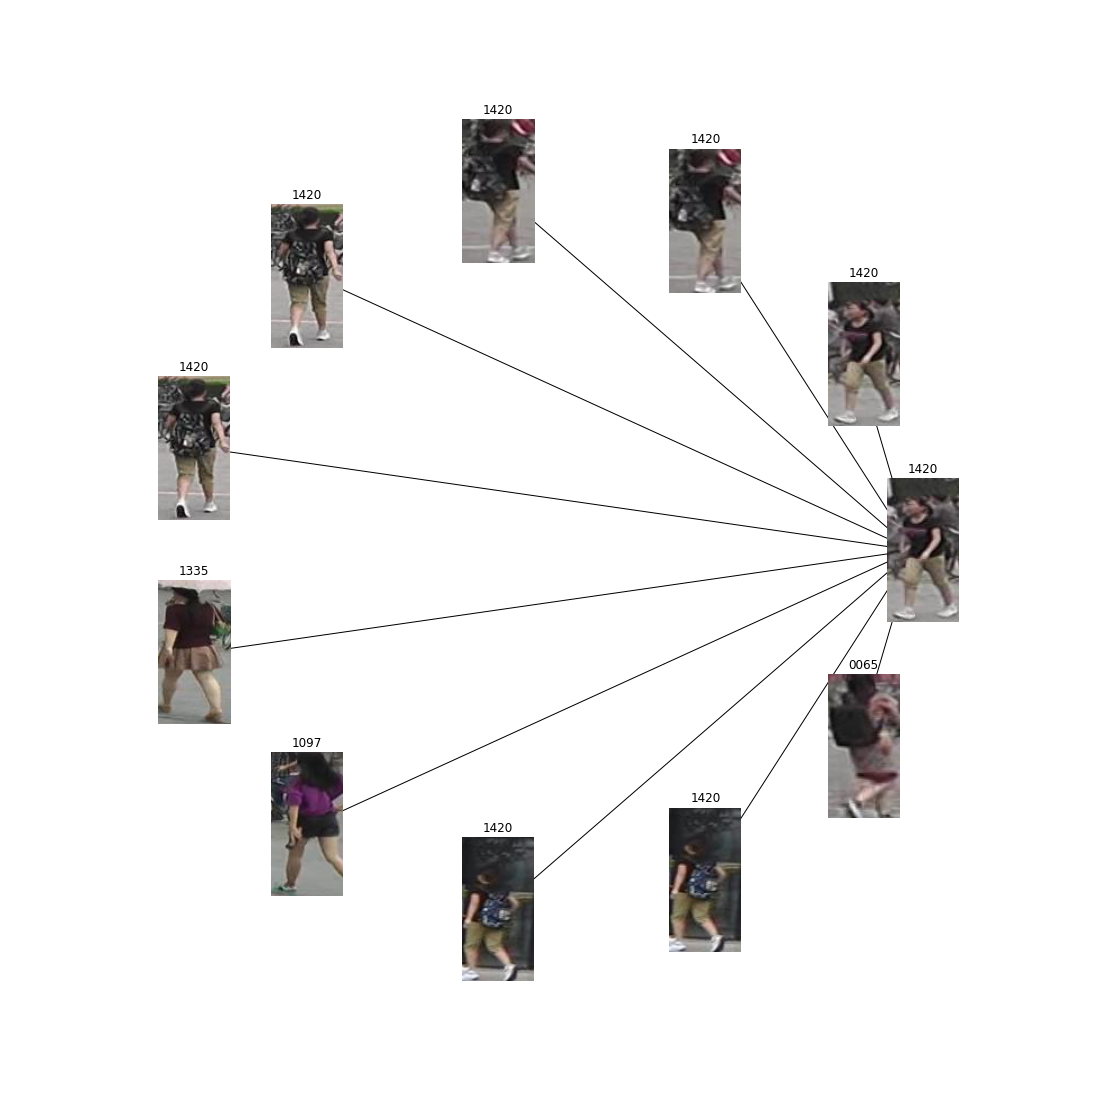

In [81]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 10);